# Fit a hierarchical rSLDS model to the worm neural recordings

In [1]:
import os, pickle, copy, sys
os.chdir(os.path.expanduser(os.path.join("~", "Projects", "zimmer")))

import numpy as np
np.random.seed(0)

In [2]:
# Plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
import matplotlib.animation as manimation

from hips.plotting.colormaps import gradient_cmap
from hips.plotting.sausage import sausage_plot
from hips.plotting.layout import create_axis_at_location

# Come up with a set of colors
import seaborn as sns
sns.set_style("white")
# sns.set_context("paper")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

%matplotlib inline

In [3]:
# Modeling stuff
import importlib
from sklearn.decomposition import PCA

from pybasicbayes.distributions import Gaussian, Regression, DiagonalRegression
from pybasicbayes.util.text import progprint_xrange
from pyhsmm.util.general import relabel_by_usage, relabel_by_permutation
from pyslds.util import get_empirical_ar_params

# Load basic pyslds models
from pyslds.models import HMMSLDS, WeakLimitStickyHDPHMMSLDS

# Load worm modeling specific stuff
import zimmer.io
importlib.reload(zimmer.io)
from zimmer.io import WormData, N_worms, find_shared_neurons, load_key

import zimmer.states
importlib.reload(zimmer.states)

import zimmer.models
importlib.reload(zimmer.models)
from zimmer.models import HierarchicalWeakLimitStickyHDPHMMSLDS, HierarchicalRecurrentSLDS, HierarchicalRecurrentOnlySLDS
from zimmer.emissions import HierarchicalDiagonalRegression

import zimmer.plotting
importlib.reload(zimmer.plotting)
from zimmer.plotting import plot_1d_continuous_states, plot_3d_continuous_states, plot_vector_field_3d, \
    plot_discrete_state_samples, plot_changepoint_prs, make_states_3d_movie, plot_3d_dynamics, \
    make_states_dynamics_movie

from zimmer.util import states_to_changepoints

In [4]:
# IO
run_num = 1
results_dir = os.path.join("results", "2017_09_07", "run{:03d}".format(run_num))
assert os.path.exists(results_dir)

# Hyperparameters
Kmax = 15      # number of latent discrete states
D_latent = 3   # latent linear dynamics' dimension
D_in = 1       # number of input dimensions

alpha = 3.     # Transition matrix concentration
gamma = 3.0    # Base state concentration
kappa = 100.   # Stickiness parameter

alpha_0 = 1.0  # Gamma prior for emission variance
beta_0 = 1.0  # Gamma prior for emission variance

In [5]:
def cached(results_name):
    def _cache(func):
        def func_wrapper(*args, **kwargs):
            results_file = os.path.join(results_dir, results_name)
            if not results_file.endswith(".pkl"):
                results_file += ".pkl"

            if os.path.exists(results_file):
                with open(results_file, "rb") as f:
                    results = pickle.load(f)
            else:
                assert os.path.exists(results_dir)
                results = func(*args, **kwargs)
                with open(results_file, "wb") as f:
                    pickle.dump(results, f)

            return results
        return func_wrapper
    return _cache

# Load the data

In [6]:
def load_data():
    # Load the data
    worm_datas = [WormData(i, name="worm{}".format(i)) for i in range(N_worms)]
    Ns = np.array([wd.N for wd in worm_datas])
    Ts = np.array([wd.T for wd in worm_datas])
    Ys = [wd.dff_deriv for wd in worm_datas]

    # Get the "true" discrete states as labeled by Zimmer
    z_true = [wd.zimmer_states for wd in worm_datas]
    perm_z_true, newlabels = relabel_by_usage(z_true, return_mapping=True)

    # Get the key
    z_key = load_key()
    perm_z_key = [z_key[i] for i in np.argsort(newlabels)]

    # Get the names of the neurons
    all_neuron_names = np.unique(np.concatenate([wd.neuron_names for wd in worm_datas]))
    N_neurons = all_neuron_names.size
    print("{} neurons across all {} worms".format(N_neurons, N_worms))

    # Find the shared neurons
    shared_neurons = find_shared_neurons(worm_datas)
    print("{} shared neurons".format(len(shared_neurons)))
    Ys_shared = []
    for wd, Y in zip(worm_datas, Ys):
        shared_indices = wd.find_neuron_indices(shared_neurons)
        Ys_shared.append(Y[:, shared_indices])

    # Construct a big dataset with all neurons for each worm
    datasets = []
    masks = []
    for wd in worm_datas:
        this_dataset = np.zeros((wd.T, N_neurons))
        this_mask = np.zeros((wd.T, N_neurons), dtype=bool)
        indices = wd.find_neuron_indices(all_neuron_names)
        for n, index in enumerate(indices):
            if index is not None:
                this_dataset[:,n] = wd.dff_deriv[:, index]
                this_mask[:,n] = True

        datasets.append(this_dataset)
        masks.append(this_mask)

    return perm_z_true, perm_z_key, N_neurons, Ts, all_neuron_names, \
           datasets, masks, \
           Ys, Ys_shared, shared_neurons

# Load the data
z_trues_full, z_key, N_neurons, Ts_full, all_neuron_names, datasets_full, data_masks_full, Ys_full, Ys_shared_full, shared_neurons = load_data()

477 neurons across all 5 worms
Potentially shared neurons:
 ['---' 'AIBL' 'AIBR' 'ALA' 'AVAL' 'AVAR' 'AVBL' 'AVBR' 'AVER' 'RIBL' 'RID'
 'RIML' 'RIMR' 'RIVL' 'RIVR' 'RMED' 'RMEL' 'RMER' 'SMDVR' 'VB01' 'VB02']
Found 15 truly shared neurons:
['AIBL', 'AIBR', 'ALA', 'AVAL', 'AVAR', 'AVBL', 'AVER', 'RID', 'RIML', 'RIMR', 'RMED', 'RMEL', 'RMER', 'VB01', 'VB02']
15 shared neurons


In [7]:
train_frac = 0.8
train_masks = [np.arange(T) < train_frac * T for T in Ts_full]
z_trues = [z[train] for z,train in zip(z_trues_full, train_masks)]
z_trues_test = [z[~train] for z,train in zip(z_trues_full, train_masks)]
Ts = [z.shape[0] for z in z_trues]
Ts_test = [z.shape[0] for z in z_trues_test]
datasets = [d[train] for d,train in zip(datasets_full, train_masks)]
datasets_test = [d[~train] for d,train in zip(datasets_full, train_masks)]
data_masks = [d[train] for d,train in zip(data_masks_full, train_masks)]
data_masks_test = [d[~train] for d,train in zip(data_masks_full, train_masks)]
Ys = [Y[train] for Y, train in zip(Ys_full, train_masks)]
Ys_test = [Y[~train] for Y, train in zip(Ys_full, train_masks)]
Ys_shared = [Y[train] for Y, train in zip(Ys_shared_full, train_masks)]
Ys_shared_test = [Y[~train] for Y, train in zip(Ys_shared_full, train_masks)]

In [8]:
# # Mask off some contiguous chunks of data for testing.
# # This forces the model to interpolate, and should hopefully
# # leverage the recurrent aspect of the model.
# train_frac = 0.75
# block_size = 10

# # Cache this function so that we get the same masks each time
# @cached("make_masks_{}".format(block_size))
# def make_masks():
#     train_masks = [np.ones_like(mask, dtype=bool) for mask in data_masks]
#     for worm, train_mask in enumerate(train_masks):
#         T_worm = train_mask.shape[0]
#         T_test = (1 - train_frac) * T_worm
#         N_blocks = int(T_test / block_size)
#         for block in range(N_blocks):
#             offset = block * T_worm // N_blocks
#             next_offset = (block + 1) * T_worm // N_blocks
#             block_start = np.random.randint(offset, next_offset - block_size)
#             train_mask[block_start:block_start + block_size] = 0
        
#     # Now combine the training mask with the data mask to get the effective, total mask
#     masks = [train_mask & data_mask for train_mask, data_mask in zip(train_masks, data_masks)]
#     test_masks = [~train_mask & data_mask for train_mask, data_mask in zip(train_masks, data_masks)]
#     return masks, test_masks

# masks, test_masks = make_masks()


In [9]:
# # Mask off some contiguous chunks of data for testing.
# # This forces the model to interpolate, and should hopefully
# # leverage the recurrent aspect of the model.
# train_frac = 0.75

# # Cache this function so that we get the same masks each time
# @cached("make_masks")
# def make_masks():
#     train_masks = [np.ones_like(mask, dtype=bool) for mask in data_masks]
#     for worm, train_mask in enumerate(train_masks):
#         T_worm = train_mask.shape[0]
#         T_train = train_frac * T_worm
#         train_mask[np.arange(T_worm) > T_train] = 0
        
#     # Now combine the training mask with the data mask to get the effective, total mask
#     masks = [train_mask & data_mask for train_mask, data_mask in zip(train_masks, data_masks)]
#     test_masks = [~train_mask & data_mask for train_mask, data_mask in zip(train_masks, data_masks)]
#     return masks, test_masks

# masks, test_masks = make_masks()
masks = data_masks


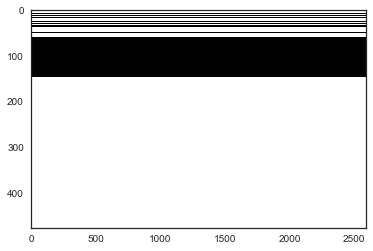

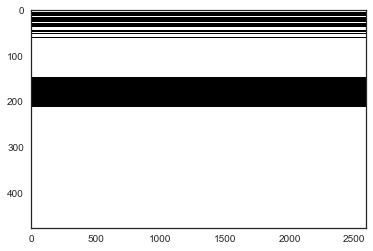

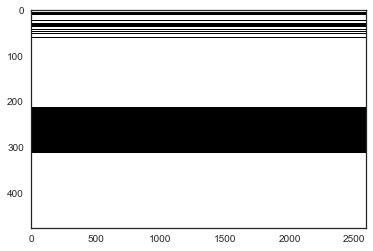

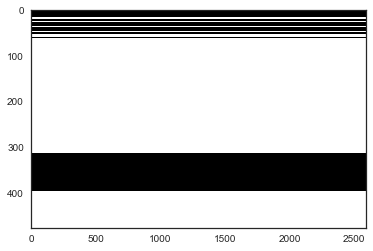

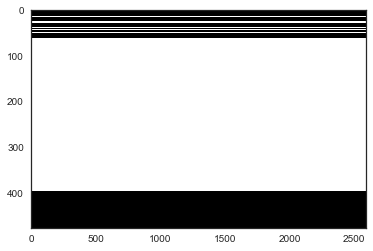

In [10]:
for mask in masks:
    plt.figure()
    plt.imshow(mask.T, interpolation="none", aspect="auto")

# Initialize latent states with PCA

90% variance explained:  9
90% variance explained:  9
90% variance explained:  13
90% variance explained:  14
90% variance explained:  12


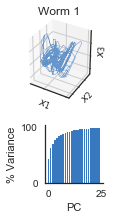

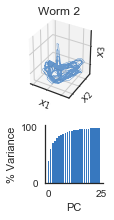

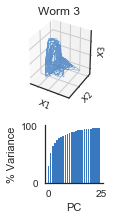

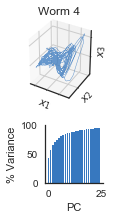

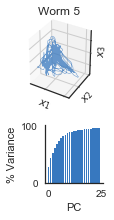

In [59]:
@cached("pca")
def fit_pca(Ys_shared):
    # Try to reproduce their plot of PC's over time
    pca = PCA(n_components=D_latent, whiten=True)
    pca.fit(np.vstack(Ys_shared))

    x_inits = [pca.transform(Y) for Y in Ys_shared]
    C_init = pca.components_.T
    return x_inits, C_init


def plot_pca_trajectories(worm, Y):
    # Try to reproduce their plot of PC's over time
    n_comps = 25
    pca = PCA(n_components=n_comps, whiten=True)
    pca.fit(Y)

    x_pca = pca.transform(Y)

    fig = plt.figure(figsize=(1.5,3.))
    ax = create_axis_at_location(fig, 0.2, 1.5, 1.1, 1.25, projection="3d")
    ax.plot(x_pca[:,0], x_pca[:,1], x_pca[:,2], lw=0.5, alpha=0.75, ls='-', color=colors[0])
    ax.set_xlabel("$x_1$", labelpad=-12)
    ax.set_ylabel("$x_2$", labelpad=-12)
    ax.set_zlabel("$x_3$", labelpad=-12)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_title("Worm {}".format(worm+1))

    # Plot percent variance explained
    ax = create_axis_at_location(fig, .55, 0.4, .8, .8, box=False)
    ax.patch.set_alpha(0.0)
    ax.bar(np.arange(n_comps),  100 * np.cumsum(pca.explained_variance_ratio_), color=colors[0])
#     ax.plot(np.arange(n_comps), 90 * np.ones(n_comps), ':r')
    ax.set_xlabel("PC")
    ax.set_ylabel("% Variance")

    print("90% variance explained: ", np.where(np.cumsum(pca.explained_variance_ratio_) > .90)[0][0])
    
    plt.savefig(os.path.join(results_dir, "pca_trajectory_worm{}.pdf".format(worm)))

    
# Fit PCA and plot the latent states
x_inits, C_init = fit_pca(Ys_shared)

# Plot PCA trajectories for first worm
for i in range(N_worms):
    plot_pca_trajectories(i, Ys[i])

In [12]:
def make_slds_parameters():
    init_dynamics_distns = [
        Gaussian(
            mu=np.zeros(D_latent),
            sigma=3*np.eye(D_latent),
            nu_0=D_latent + 2, sigma_0=3. * np.eye(D_latent),
            mu_0=np.zeros(D_latent), kappa_0=1.0,
        )
        for _ in range(Kmax)]

    # dynamics_hypparams = get_empirical_ar_params(
    #     [np.hstack((np.vstack(pca_trajs)[:,:P], np.ones((sum(Ts), 1))))],
    #     dynamics_hypparams)

    As = [np.hstack((0.99 * np.eye(D_latent), np.zeros((D_latent, D_in)))) for _ in range(Kmax)]
    dynamics_distns = [
        Regression(
            A=As[k],
            sigma=np.eye(D_latent),
            nu_0=D_latent + D_in + 2,
            S_0=np.eye(D_latent),
            M_0=np.hstack((np.eye(D_latent), np.zeros((D_latent, D_in)))),
            K_0=np.eye(D_latent + D_in),
        )
        for k in range(Kmax)]

    emission_distns = \
        DiagonalRegression(
            N_neurons, D_latent + D_in,
            alpha_0=alpha_0, beta_0=beta_0)

    return init_dynamics_distns, dynamics_distns, emission_distns

# Fit standard LDS models

In [13]:
def _fit_lds(x_inits, ys, masks, N_samples=500):
    print("Fitting standard LDS")
    init_dynamics_distns, dynamics_distns, emission_distns = \
        make_slds_parameters()
        
    x_inits = [None] * len(ys) if x_inits is None else x_inits
    
    # LDS is a switching LDS with one state
    lds = HMMSLDS(
        init_dynamics_distns=init_dynamics_distns[:1],
        dynamics_distns=dynamics_distns[:1],
        emission_distns=emission_distns,
        alpha=alpha,
        init_state_distn='uniform')

    # Add the data
    for y, mask, xi in zip(ys, masks, x_inits):
        T = y.shape[0]
        inputs = np.ones((T, D_in))
        lds.add_data(data=y, mask=mask, inputs=inputs)

        # Initialize continuous latent states
        if xi is not None:
            lds.states_list[-1].gaussian_states = xi[:, :D_latent]

    # Resample parameters once to be consistent with x_init
    lds.resample_parameters()

    # Fit the model with MCMC
    def evaluate(model):
        ll = model.log_likelihood()
        return ll

    def update(model):
        model.resample_model()
        return evaluate(model)

    lls  = [update(lds) for itr in progprint_xrange(N_samples)]
    lls = np.array(lls)

    # Compute the smoothed continuous state trajectories
    for states in lds.states_list:
        states.info_E_step()
    x_finals = [s.smoothed_mus for s in lds.states_list]
    sigma_x_finals = [s.smoothed_sigmas for s in lds.states_list]

    return lds, lls, x_finals, sigma_x_finals

In [14]:
Ys_shared[0].shape

(2592, 15)

In [15]:
# Fit an LDS to all the data
fit_joint_lds = cached("lds_joint")(_fit_lds)
lds, lds_lls, lds_x_finals, lds_sigma_x_finals = \
        fit_joint_lds(x_inits=x_inits, ys=datasets, masks=masks)

In [16]:
# Fit an LDS to each worm individually
lds_results = []
for worm in range(N_worms):
    fit_lds = cached("lds_worm_{}".format(worm+1))(_fit_lds)
    lds_results.append(fit_lds(x_inits=x_inits[worm:worm+1], ys=datasets[worm:worm+1], masks=masks[worm:worm+1]))
ldss, lds_llss, lds_x_finalss, lds_sigma_x_finalss = zip(*lds_results)
    

# Fit standard SLDS models

In [17]:
def _fit_slds(z_inits, x_inits, ys, masks, N_samples=500):
    print("Fitting standard SLDS")
    init_dynamics_distns, dynamics_distns, emission_distns = \
        make_slds_parameters()
        
    z_inits = [None] * len(ys) if z_inits is None else z_inits
    x_inits = [None] * len(ys) if x_inits is None else x_inits
    
    slds = WeakLimitStickyHDPHMMSLDS(
        init_dynamics_distns=init_dynamics_distns,
        dynamics_distns=dynamics_distns,
        emission_distns=emission_distns,
        alpha=alpha,
        gamma=gamma,
        kappa=kappa,
        init_state_distn='uniform')

    # Add the data
    for y, mask, xi, zi in zip(ys, masks, x_inits, z_inits):
        T = y.shape[0]
        inputs = np.ones((T, D_in))
        slds.add_data(data=y, mask=mask, inputs=inputs)

        # Initialize continuous latent states
        if xi is not None:
            slds.states_list[-1].gaussian_states = xi[:, :D_latent]

        # Initialize discrete latent states
        if zi is not None:
            slds.states_list[-1].stateseq = zi
        else:
            runlen = 10
            z0 = np.random.choice(Kmax, size=(T // 10))
            z0 = np.repeat(z0, runlen)
            z0 = z0[:T] if len(z0) > T else z0
            z0 = np.concatenate((z0, z0[-1] * np.ones(T - len(z0))))
            z0 = z0.astype(np.int32)
            assert len(z0) == T
            slds.states_list[-1].stateseq = z0

    # Resample parameters once to be consistent with x_init
    slds.resample_parameters()

    # Fit the model with MCMC
    def evaluate(model):
        ll = model.log_likelihood()
        stateseqs = copy.deepcopy(model.stateseqs)
        return ll, stateseqs

    def update(model):
        model.resample_model()
        return evaluate(model)

    smpls = [update(slds) for itr in progprint_xrange(N_samples)]

    # Convert the samples into numpy arrays for faster pickling
    lls, raw_z_smpls = zip(*smpls)
    lls = np.array(lls)

    # stateseqs is a list of lists of arrays of "shape" (N_samples x N_worms x T_worm)
    # get one list of arrays for each worm
    z_smpls = []
    for w in range(len(ys)):
        z_smpls_w = np.array([z_smpl[w] for z_smpl in raw_z_smpls])
        z_smpls.append(z_smpls_w)

    perm_z_smpls, iperm = relabel_by_usage(z_smpls, return_mapping=True)
    perm = np.argsort(iperm)
    z_finals = [relabel_by_permutation(s.stateseq, iperm) for s in slds.states_list]
    
    # Permute the dynamics and transition distribution
    perm_init_dynamics_distns = [slds.init_dynamics_distns[i] for i in perm]
    perm_dynamics_distns = [slds.dynamics_distns[i] for i in perm]
    perm_trans_matrix = slds.trans_distn.trans_matrix[np.ix_(perm, perm)]
    
    # Update the model accordingly
    slds.init_dynamics_distns = perm_init_dynamics_distns
    slds.dynamics_distns = perm_dynamics_distns
    slds.trans_distn.trans_matrix = perm_trans_matrix
    for s, zp in zip(slds.states_list, z_finals):
        s.stateseq = zp.copy()

    # Compute the smoothed continuous state trajectories
    for states in slds.states_list:
        states.info_E_step()
    x_finals = [s.smoothed_mus for s in slds.states_list]
    sigma_x_finals = [s.smoothed_sigmas for s in slds.states_list]

    return slds, lls, perm_z_smpls, perm_dynamics_distns, z_finals, x_finals, sigma_x_finals

In [18]:
fit_joint_slds = cached("slds_joint")(_fit_slds)
slds, slds_lls, slds_z_smpls, slds_dynamics_distns, \
    slds_z_finals, slds_x_finals, slds_sigma_x_finals = \
        fit_joint_slds(z_inits=None, x_inits=x_inits, ys=datasets, masks=masks)

In [19]:
# Fit an SLDS to each worm individually
slds_results = []
for worm in range(N_worms):
    fit_slds = cached("slds_worm_{}".format(worm+1))(_fit_slds)
    slds_results.append(fit_slds(z_inits=None, x_inits=x_inits[worm:worm+1], 
                                 ys=datasets[worm:worm+1], masks=masks[worm:worm+1]))
sldss, slds_llss, slds_z_smplss, slds_dynamics_distnss, \
slds_z_finalss, slds_x_finalss, slds_sigma_x_finalss = zip(*slds_results)
    

# Fit hierarchical SLDS models

In [20]:
def make_hierarchical_slds_parameters():
    init_dynamics_distns = [
        Gaussian(
            mu=np.zeros(D_latent),
            sigma=3*np.eye(D_latent),
            nu_0=D_latent + 2, sigma_0=3. * np.eye(D_latent),
            mu_0=np.zeros(D_latent), kappa_0=1.0,
        )
        for _ in range(Kmax)]

    # dynamics_hypparams = get_empirical_ar_params(
    #     [np.hstack((np.vstack(pca_trajs)[:,:P], np.ones((sum(Ts), 1))))],
    #     dynamics_hypparams)

    As = [np.hstack((0.99 * np.eye(D_latent), np.zeros((D_latent, D_in)))) for _ in range(Kmax)]
    dynamics_distns = [
        Regression(
            A=As[k],
            sigma=np.eye(D_latent),
            nu_0=D_latent + D_in + 2,
            S_0=np.eye(D_latent),
            M_0=np.hstack((np.eye(D_latent), np.zeros((D_latent, D_in)))),
            K_0=np.eye(D_latent + D_in),
        )
        for k in range(Kmax)]

    emission_distns = \
        HierarchicalDiagonalRegression(
            N_neurons, D_latent + D_in, N_worms,
            alpha_0=alpha_0, beta_0=beta_0)

    return init_dynamics_distns, dynamics_distns, emission_distns

In [21]:
@cached("hslds")
def fit_hslds(z_inits, x_inits, ys, masks, N_samples=500, N_vbem_steps=100):
    print("Fitting hierarchical SLDS")
    init_dynamics_distns, dynamics_distns, emission_distns = \
        make_hierarchical_slds_parameters()

    hslds = HierarchicalWeakLimitStickyHDPHMMSLDS(
        init_dynamics_distns=init_dynamics_distns,
        dynamics_distns=dynamics_distns,
        emission_distns=emission_distns,
        alpha=alpha,
        gamma=gamma,
        kappa=kappa,
        init_state_distn='uniform')

    # Add the data
    for worm, (y, mask) in enumerate(zip(ys, masks)):
        T = Ts[worm]
        inputs = np.ones((T, D_in))
        hslds.add_data(data=y, mask=mask, group=worm, inputs=inputs)

        # Initialize continuous latent states
        if x_inits is not None:
            hslds.states_list[-1].gaussian_states = x_inits[worm][:, :D_latent]

        # Initialize discrete latent states
        if z_inits is not None:
            hslds.states_list[-1].stateseq = z_inits[worm]
        else:
            runlen = 10
            z0 = np.random.choice(Kmax, size=(T // 10))
            z0 = np.repeat(z0, runlen)
            z0 = z0[:T] if len(z0) > T else z0
            z0 = np.concatenate((z0, z0[-1] * np.ones(T - len(z0))))
            z0 = z0.astype(np.int32)
            assert len(z0) == T
            hslds.states_list[-1].stateseq = z0

    # Resample parameters once to be consistent with x_init
    hslds.resample_parameters()

    # Fit the model with MCMC
    def evaluate(model):
        # ll = model.log_likelihood()
        ll = model.heldout_log_likelihood(masks)
        stateseqs = copy.deepcopy(model.stateseqs)
        return ll, stateseqs

    def gibbs_update(model):
        model.resample_model()
        return evaluate(model)
    
    # Initialize with Gibbs
    smpls = [evaluate(hslds)] + [gibbs_update(hslds) for itr in progprint_xrange(N_samples)]

    # Convert the samples into numpy arrays for faster pickling
    lls, raw_z_smpls = zip(*smpls)
    lls = np.array(lls)

    # stateseqs is a list of lists of arrays of "shape" (N_samples x N_worms x T_worm)
    # get one list of arrays for each worm
    z_smpls = []
    for w in range(N_worms):
        z_smpls_w = np.array([z_smpl[w] for z_smpl in raw_z_smpls])
        z_smpls.append(z_smpls_w)

    # for s in hslds.states_list:
    #     s.clear_caches()
    # print("Final LL: ", hslds.log_likelihood())
        
    perm_z_smpls, iperm = relabel_by_usage(z_smpls, return_mapping=True)
    perm = np.argsort(iperm)
    z_finals = [relabel_by_permutation(s.stateseq, iperm) for s in hslds.states_list]
    
    # Permute the dynamics and transition distribution
    perm_init_dynamics_distns = [hslds.init_dynamics_distns[i] for i in perm]
    perm_dynamics_distns = [hslds.dynamics_distns[i] for i in perm]
    perm_trans_matrix = hslds.trans_distn.trans_matrix[np.ix_(perm, perm)]
    
    # Update the model accordingly
    hslds.init_dynamics_distns = perm_init_dynamics_distns
    hslds.dynamics_distns = perm_dynamics_distns
    hslds.trans_distn.trans_matrix = perm_trans_matrix
    for s, zp in zip(hslds.states_list, z_finals):
        s.stateseq = zp.copy()
        
    # Compute the smoothed continuous state trajectories
    for states in hslds.states_list:
        states.info_E_step()
    x_finals = [s.smoothed_mus for s in hslds.states_list]
    sigma_x_finals = [s.smoothed_sigmas for s in hslds.states_list]

    # for s in hslds.states_list:
    #     s.clear_caches()
    # print("Permuted Final LL: ", hslds.log_likelihood())

    return hslds, lls, perm_z_smpls, perm_dynamics_distns, z_finals, x_finals, sigma_x_finals

hslds0, hslds_lls0, hslds_z_smpls0, hslds_dynamics_distns0, \
    hslds_z_finals0, hslds_x_finals0, hslds_sigma_x_finals0 = \
        fit_hslds(z_inits=None, x_inits=x_inits, ys=datasets, masks=masks, N_samples=500)

In [22]:
@cached("hslds_vbem")
def fit_hslds_with_vbem(hslds, N_vbem_steps=100):
    print("Fitting hierarchical SLDS with VBEM")
        
    for s in hslds.states_list:
        s._init_mf_from_gibbs()
        s.vb_E_step_gaussian_states()
        
    # Refine with VBEM
    def evaluate(model):
        # ll = model.log_likelihood()
        ll = model.heldout_log_likelihood(masks)
        stateseqs = copy.deepcopy(model.stateseqs)
        return ll, stateseqs
    
    def vbem_update(model):
        model.VBEM_step()
        return evaluate(model)

    smpls = [evaluate(hslds)] + [vbem_update(hslds) for itr in progprint_xrange(N_vbem_steps)]

    # Convert the samples into numpy arrays for faster pickling
    lls, raw_z_smpls = zip(*smpls)
    lls = np.array(lls)

    # stateseqs is a list of lists of arrays of "shape" (N_samples x N_worms x T_worm)
    # get one list of arrays for each worm
    z_smpls = []
    for w in range(N_worms):
        z_smpls_w = np.array([z_smpl[w] for z_smpl in raw_z_smpls])
        z_smpls.append(z_smpls_w)

    z_finals = hslds.stateseqs
    x_finals = [s.smoothed_mus for s in hslds.states_list]
    sigma_x_finals = [s.smoothed_sigmas for s in hslds.states_list]
    
    # Clear the expected stats before saving
    for s in hslds.states_list:
        s.E_init_stats = None
        s.E_dynamics_stats = None
        s.E_emission_stats = None

    return hslds, lls, z_smpls, hslds.dynamics_distns, z_finals, x_finals, sigma_x_finals

hslds = copy.deepcopy(hslds0)

hslds, hslds_lls, hslds_z_smpls, hslds_dynamics_distns, \
    hslds_z_finals, hslds_x_finals, hslds_sigma_x_finals = \
        fit_hslds_with_vbem(hslds, N_vbem_steps=10)

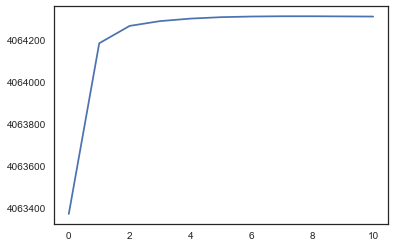

In [23]:
# plt.plot(np.concatenate([hslds_lls0[1:], hslds_lls], axis=0))
plt.plot(np.concatenate([hslds_lls], axis=0))

# Now fit a hierarchical _recurrent_ hSLDS

In [24]:
# Fit an rhSLDS from scratch -- no initialization except x 
# # @cached("rhslds")
# def fit_hrslds_noinit(ys, masks, N_steps=100, x_inits=None, z_inits=None):
#     print("Fitting hierarchical recurrent SLDS")
#     init_dynamics_distns, dynamics_distns, emission_distns = \
#         make_hierarchical_slds_parameters()

#     rslds = HierarchicalRecurrentSLDS(
#         init_dynamics_distns=init_dynamics_distns,
#         dynamics_distns=dynamics_distns,
#         emission_distns=emission_distns,
#         alpha=alpha,
#         init_state_distn='uniform')

#     # Add the data
#     for worm, (y, mask) in enumerate(zip(ys, masks)):
#         T = Ts[worm]
#         inputs = np.ones((T, D_in))
#         rslds.add_data(data=y, mask=mask, group=worm, inputs=inputs)

#         # Initialize continuous latent states
#         if x_inits is not None:
#             rslds.states_list[-1].gaussian_states = x_inits[worm][:, :D_latent]

#         # Initialize discrete latent states
#         if z_inits is not None:
#             rslds.states_list[-1].stateseq = z_inits[worm]
#         else:
#             runlen = 10
#             z0 = np.random.choice(Kmax, size=(T // 10))
#             z0 = np.repeat(z0, runlen)
#             z0 = z0[:T] if len(z0) > T else z0
#             z0 = np.concatenate((z0, z0[-1] * np.ones(T - len(z0))))
#             z0 = z0.astype(np.int32)
#             assert len(z0) == T
#             rslds.states_list[-1].stateseq = z0
        
#         # Initialize vbem params
#         rslds.states_list[-1]._init_vbem_from_gibbs()
#         rslds.states_list[-1]._variational_entropy = 0
        
#     rslds._vb_M_step()

#     # Fit the model with VBEM
#     def evaluate(model):
#         ll = model.heldout_log_likelihood(masks)
#         stateseqs = copy.deepcopy(model.stateseqs)
#         return ll, stateseqs

#     def update(model, itr):
#         model.VBEM_step()
#         return evaluate(model)


#     smpls = [evaluate(rslds)] + [update(rslds, itr) for itr in progprint_xrange(N_steps)]

#     # Convert the samples into numpy arrays for faster pickling
#     lls, raw_z_smpls = zip(*smpls)
#     lls = np.array(lls)

#     # stateseqs is a list of lists of arrays of "shape" (N_samples x N_worms x T_worm)
#     # get one list of arrays for each worm
#     z_smpls = []
#     for w in range(N_worms):
#         z_smpls_w = np.array([z_smpl[w] for z_smpl in raw_z_smpls])
#         z_smpls.append(z_smpls_w)

#     z_finals = rslds.stateseqs
#     x_finals = [s.smoothed_mus for s in rslds.states_list]
#     sigma_x_finals = [s.smoothed_sigmas for s in rslds.states_list]

#     # Clear the expected stats before saving
#     for s in rslds.states_list:
#         s.E_init_stats = None
#         s.E_dynamics_stats = None
#         s.E_emission_stats = None
    
#     return rslds, lls, z_smpls, rslds.dynamics_distns, z_finals, x_finals, sigma_x_finals

# # Make and fit the hierarchical rSLDS
# hrslds, hrslds_lls, hrslds_z_smpls, hrslds_dynamics_distns, \
# hrslds_z_finals, hrslds_x_finals, hrslds_sigma_x_finals = \
#     fit_hrslds_noinit(ys=datasets, masks=masks, N_steps=100, x_inits=x_inits)

In [25]:
@cached("rhslds")
def fit_hrslds(ys, masks, N_steps=100, init_hslds=None):
    print("Fitting hierarchical recurrent SLDS")
    init_dynamics_distns, dynamics_distns, emission_distns = \
        make_hierarchical_slds_parameters()

    rslds = HierarchicalRecurrentSLDS(
        init_dynamics_distns=init_dynamics_distns,
        dynamics_distns=dynamics_distns,
        emission_distns=emission_distns,
        alpha=alpha,
        init_state_distn='uniform')

    # Add the data
    for worm, (y, mask) in enumerate(zip(ys, masks)):
        T = Ts[worm]
        inputs = np.ones((T, D_in))
        rslds.add_data(data=y, mask=mask, group=worm, inputs=inputs)

    # If we've been given an hSLDS to initialize from, use its states and parameters
    if init_hslds is not None:            
        # Copy over the parameters
        rslds.init_dynamics_distns = copy.deepcopy(init_hslds.init_dynamics_distns)
        rslds.dynamics_distns = copy.deepcopy(init_hslds.dynamics_distns)
        rslds.emission_distns = copy.deepcopy(init_hslds.emission_distns)

        # Copy over the latent states
        assert len(init_hslds.states_list) == len(ys)
        for s1, s2 in zip(init_hslds.states_list, rslds.states_list):
            # Copy the sampled states
            s2.stateseq = s1.stateseq.copy()
            s2.gaussian_states = s1.gaussian_states.copy()

            # Copy the expected states and statistics
            s2.expected_states = s1.expected_states.copy()
            s2.smoothed_mus = s1.smoothed_mus.copy()
            s2.smoothed_sigmas = s1.smoothed_sigmas.copy()
            
            if s1.E_emission_stats is None:
                s1.vb_E_step_gaussian_states()
                
            s2.E_init_stats = copy.deepcopy(s1.E_init_stats)
            s2.E_dynamics_stats = copy.deepcopy(s1.E_dynamics_stats)
            s2.E_emission_stats = copy.deepcopy(s1.E_emission_stats)
        
            s2.expected_joints = s2.expected_states[:-1, :, None] * s2.expected_states[1:, None, :]
            s2._set_expected_trans_stats()

        
        # Initialize the transition model with the latent states
        rslds.initialize_transitions_from_gibbs()
        
        # Initialize the transition model to ignore continuous location
        # rslds.trans_distn.W *= 0
        # rslds.trans_distn.logpi = np.log(init_hslds.trans_distn.trans_matrix)

        # Initialize the auxiliary latent variables to be consistent
        # with the discrete and continuous latent states as well as 
        # the transition model
        for s in rslds.states_list:
            # s._init_vbem_from_gibbs()
            s.vbem_update_auxiliary_vars(n_iter=100)
            s._variational_entropy = 0

    else:
        for s in rslds.states_list:
            s._init_vbem_from_gibbs()
            s._variational_entropy = 0

    # Fit the model with VBEM
    def evaluate(model):
        ll = model.heldout_log_likelihood(masks)
        stateseqs = copy.deepcopy(model.stateseqs)
        return ll, stateseqs

    def update(model, itr):
        model.VBEM_step()      
        # E step
#         for state in model.states_list:
#             state.vb_E_step()
#             if itr > 10:
#              state.vb_E_step_discrete_states()
#              state.vb_E_step_gaussian_states()
#              state.vbem_update_auxiliary_vars()
        
#         # M step
#         model._M_step_init_state_distn()
#         # model._M_step_trans_distn()
#         model._M_step_init_dynamics_distn()
#         model._M_step_dynamics_distn()
#         model._M_step_emission_distn()
        return evaluate(model)


    smpls = [evaluate(rslds)] + [update(rslds, itr) for itr in progprint_xrange(N_steps)]

    # Convert the samples into numpy arrays for faster pickling
    lls, raw_z_smpls = zip(*smpls)
    lls = np.array(lls)

    # stateseqs is a list of lists of arrays of "shape" (N_samples x N_worms x T_worm)
    # get one list of arrays for each worm
    z_smpls = []
    for w in range(N_worms):
        z_smpls_w = np.array([z_smpl[w] for z_smpl in raw_z_smpls])
        z_smpls.append(z_smpls_w)

    z_finals = rslds.stateseqs
    x_finals = [s.smoothed_mus for s in rslds.states_list]
    sigma_x_finals = [s.smoothed_sigmas for s in rslds.states_list]

    # Clear the expected stats before saving
    for s in rslds.states_list:
        s.E_init_stats = None
        s.E_dynamics_stats = None
        s.E_emission_stats = None
    
    return rslds, lls, z_smpls, rslds.dynamics_distns, z_finals, x_finals, sigma_x_finals

# Make and fit the hierarchical rSLDS
hrslds, hrslds_lls, hrslds_z_smpls, hrslds_dynamics_distns, \
hrslds_z_finals, hrslds_x_finals, hrslds_sigma_x_finals = \
    fit_hrslds(ys=datasets, masks=masks, N_steps=0, init_hslds=hslds)

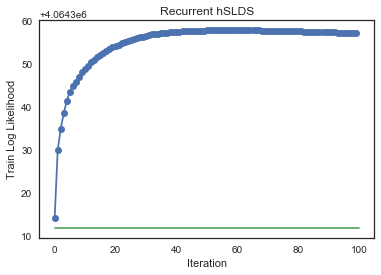

In [26]:
plt.plot(hrslds_lls[1:], '-o')
# tmp = hslds0.heldout_log_likelihood(masks)
# plt.plot(tmp * np.ones(len(hrslds_lls)))

tmp = hslds.heldout_log_likelihood(masks)
plt.plot(tmp * np.ones(len(hrslds_lls)))
plt.xlabel("Iteration")
plt.ylabel("Train Log Likelihood")
plt.title("Recurrent hSLDS")

# Plot LDS results

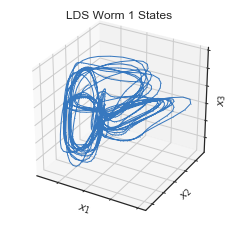

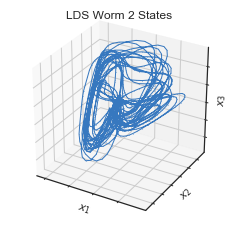

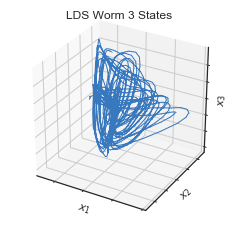

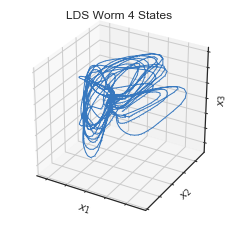

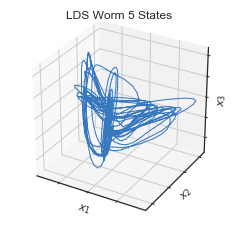

In [27]:
for worm in range(N_worms):
    plot_3d_continuous_states(lds_x_finals[worm], np.zeros(Ts[worm], dtype=np.int32), colors,
                              figsize=(4, 4),
                              title="LDS Worm {} States".format(worm + 1),
                              results_dir=results_dir,
                              filename="lds_x_worm_{}.pdf".format(worm + 1),
                              lw=1)

# Plot SLDS results

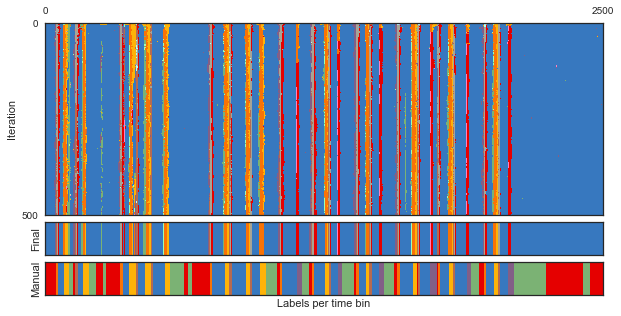

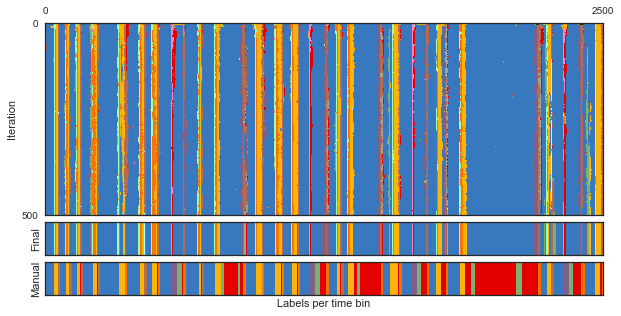

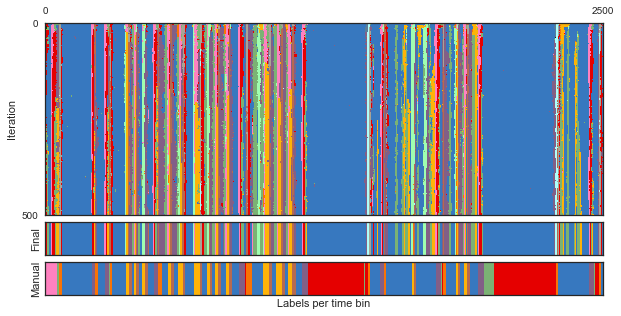

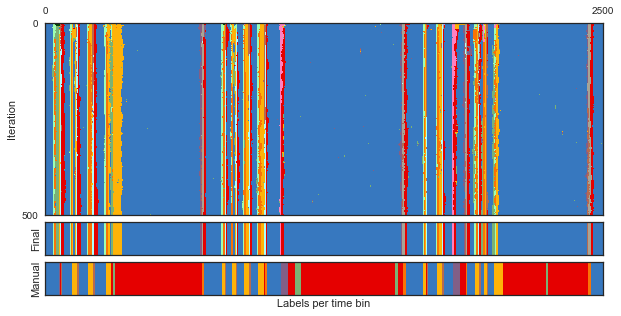

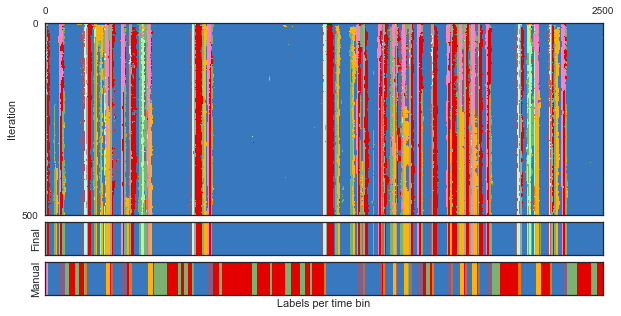

In [28]:
for worm in range(N_worms):
    plot_discrete_state_samples(
        slds_z_smpls[worm], z_trues[worm], Kmax,
        filepath=os.path.join(results_dir, "slds_z_samples_worm{}.pdf".format(worm+1)))
    

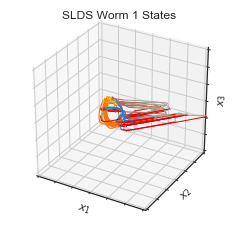

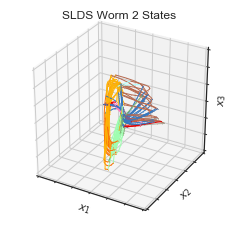

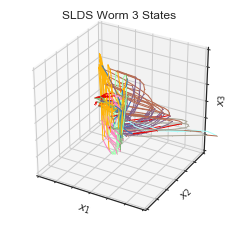

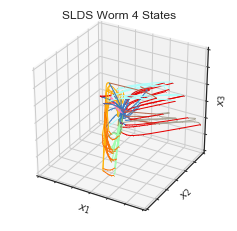

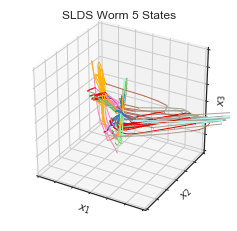

In [29]:
for worm in range(N_worms):
    plot_3d_continuous_states(slds_x_finals[worm], slds_z_finals[worm], colors,
                              figsize=(4, 4),
                              title="SLDS Worm {} States".format(worm + 1),
                              lim=6,
                              results_dir=results_dir,
                              filename="slds_x_worm_{}.pdf".format(worm + 1),
                              lw=1)

# Plot hSLDS results

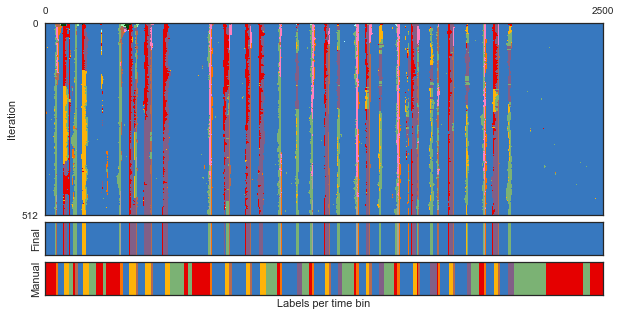

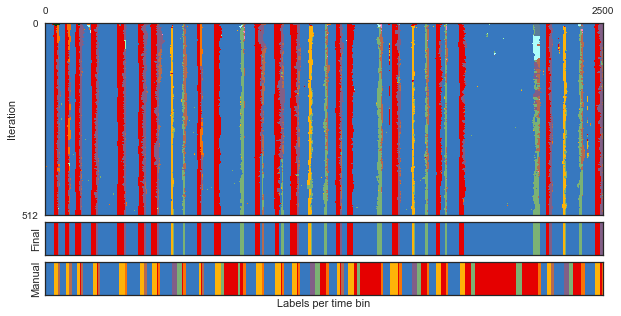

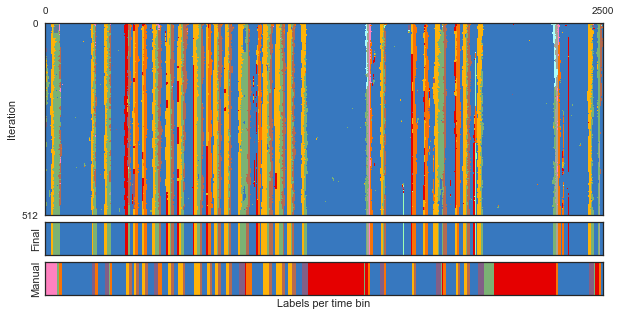

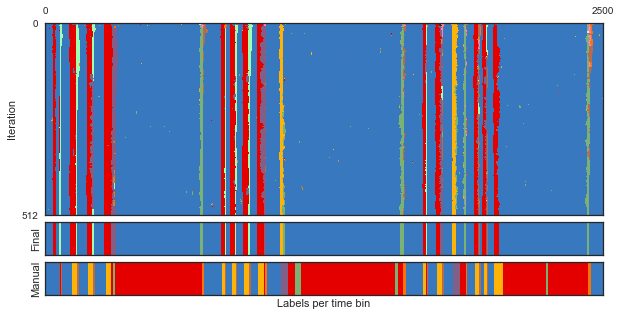

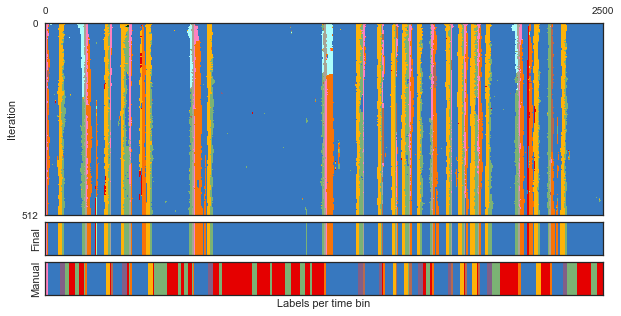

In [60]:
for worm in range(N_worms):
    plot_discrete_state_samples(
        np.vstack((hslds_z_smpls0[worm], hslds_z_smpls[worm])), 
        z_trues[worm], Kmax,
        filepath=os.path.join(results_dir, "hslds_z_samples_worm{}.pdf".format(worm+1)))
    

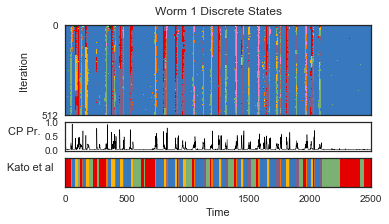

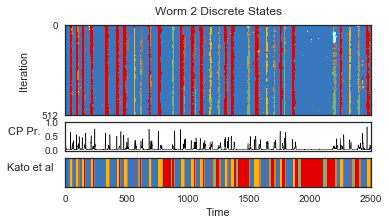

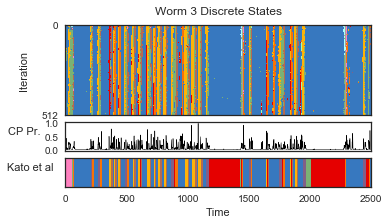

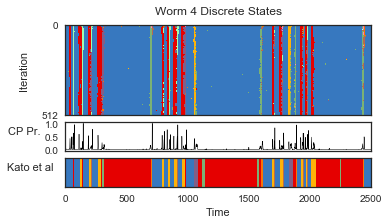

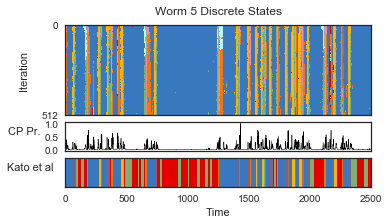

In [63]:
for worm in range(N_worms):
    plot_changepoint_prs(np.vstack((hslds_z_smpls0[worm], hslds_z_smpls[worm])), 
                         z_trues[worm],
                         title="Worm {} Discrete States".format(worm+1),
                         plt_slice=(0,2500),
                         filepath=os.path.join(results_dir, "hslds_cps_worm{}.pdf".format(worm+1)))
    

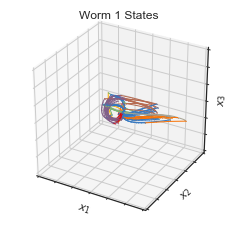

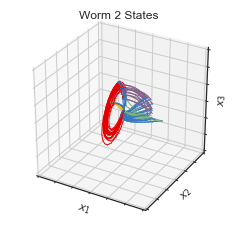

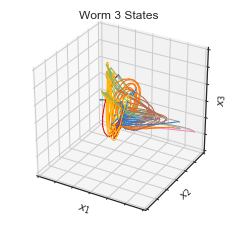

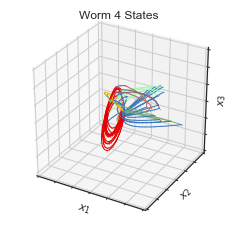

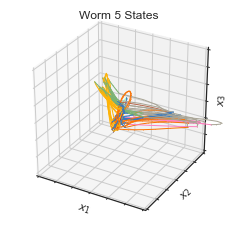

In [32]:
for worm in range(N_worms):
    plot_3d_continuous_states(hslds_x_finals[worm], hslds_z_finals[worm], colors,
                              figsize=(4, 4),
                              title="Worm {} States".format(worm + 1),
                              lim=6,
                              results_dir=results_dir,
                              filename="hslds_x_worm_{}.pdf".format(worm + 1),
                              lw=1)

100%|██████████| 360/360 [00:31<00:00, 11.60it/s]


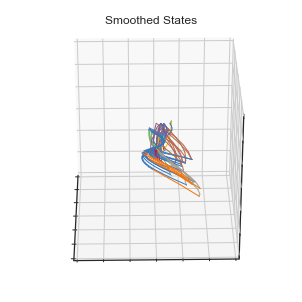

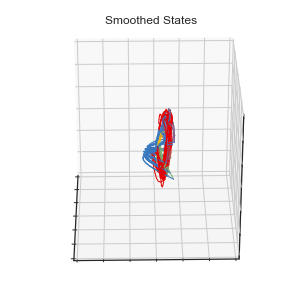

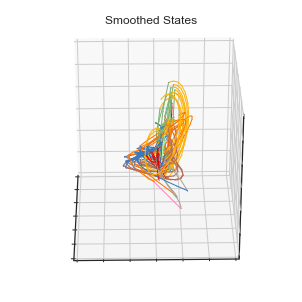

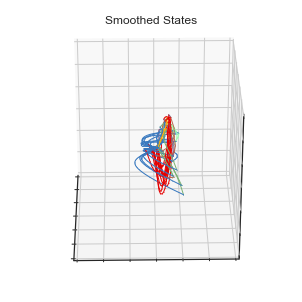

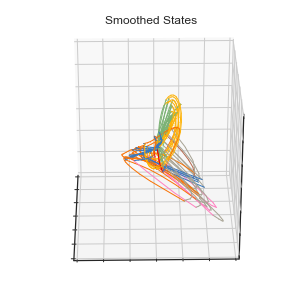

In [64]:
for worm in range(N_worms):
    make_states_3d_movie(hslds_z_finals[worm], hslds_x_finals[worm],
                         title="Smoothed States",
                         lim=6,
                         filepath=os.path.join(results_dir, "hslds_x_worm{}.mp4".format(worm+1)))

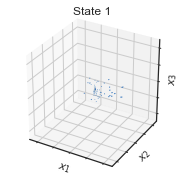

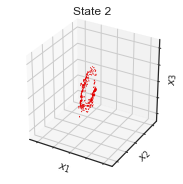

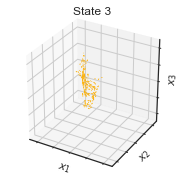

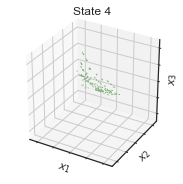

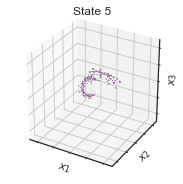

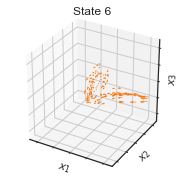

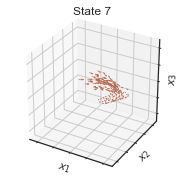

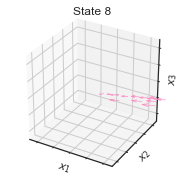

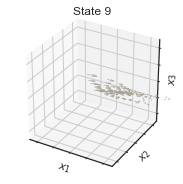

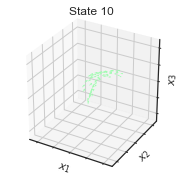

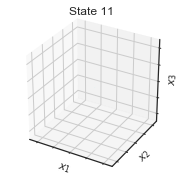

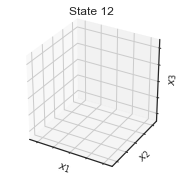

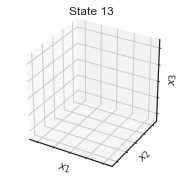

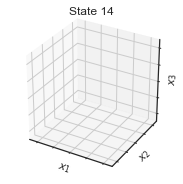

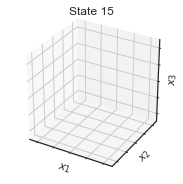

In [65]:
 plot_3d_dynamics(
    hslds_dynamics_distns, np.concatenate(hslds_z_finals), np.vstack(hslds_x_finals),
    colors=colors,
    lim=6,
    filepath=os.path.join(results_dir, "hslds_dynamics"))

100%|██████████| 360/360 [00:15<00:00, 27.61it/s]


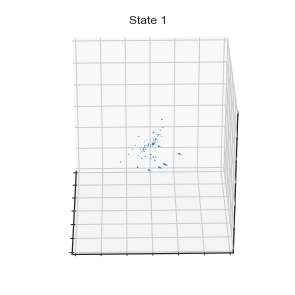

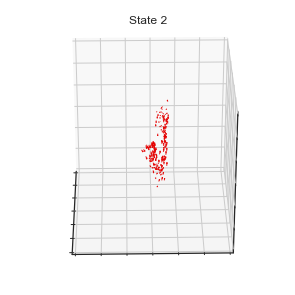

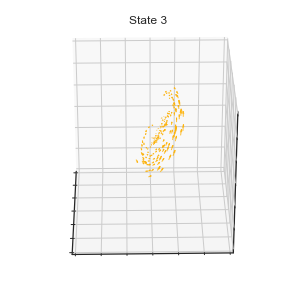

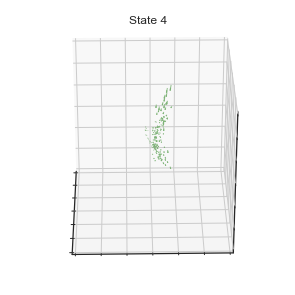

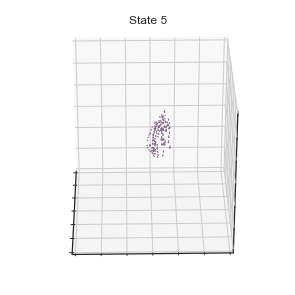

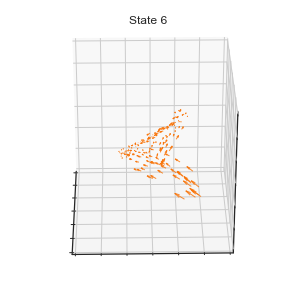

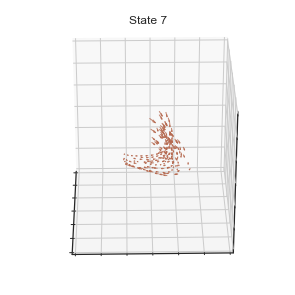

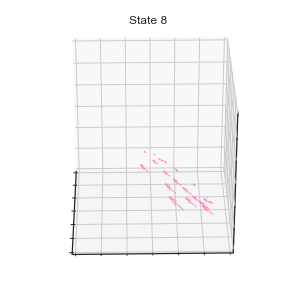

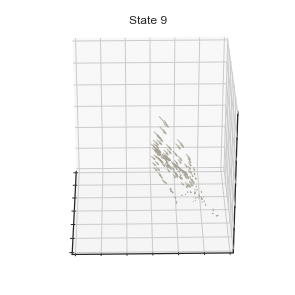

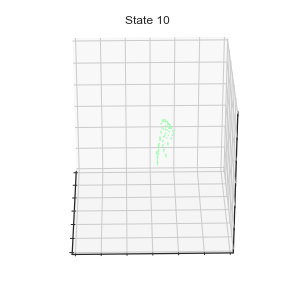

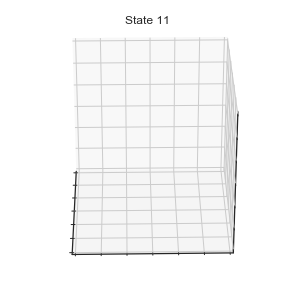

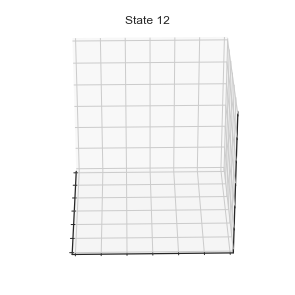

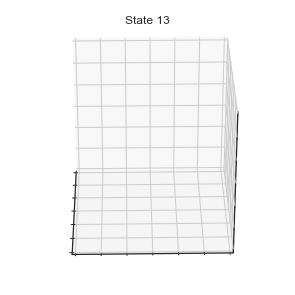

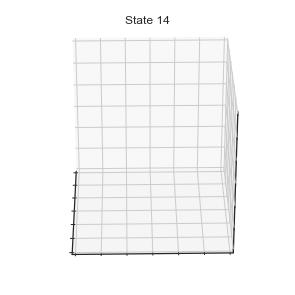

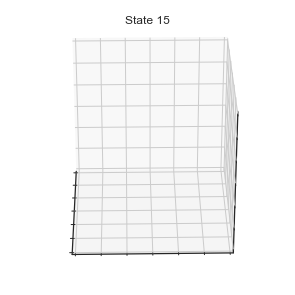

In [66]:
 make_states_dynamics_movie(
    hslds_dynamics_distns, np.concatenate(hslds_z_finals), np.vstack(hslds_x_finals),
    colors=colors,
    lim=6,
    filepath=os.path.join(results_dir, "hslds_dynamics"))

# Plot recurrent hSLDS results

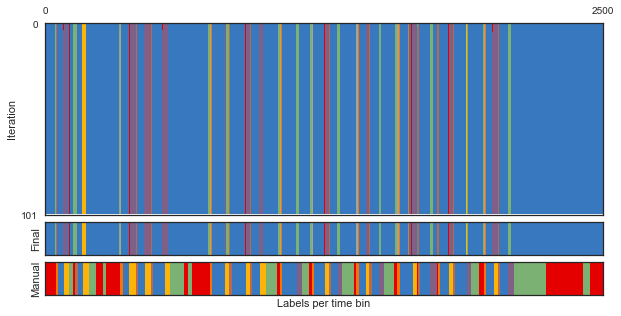

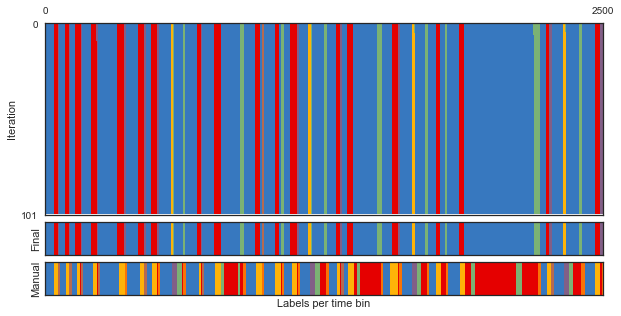

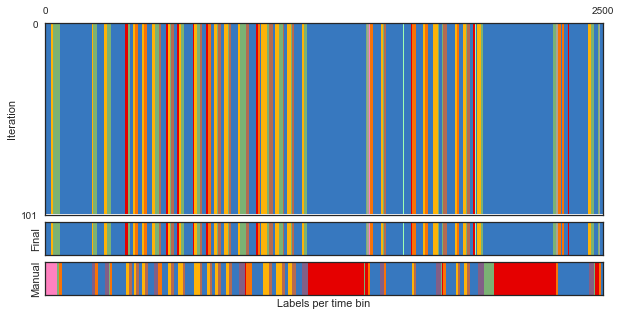

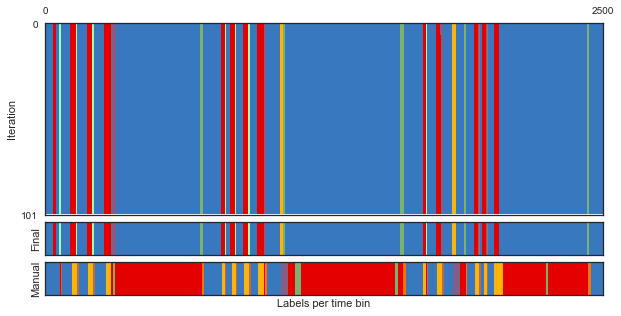

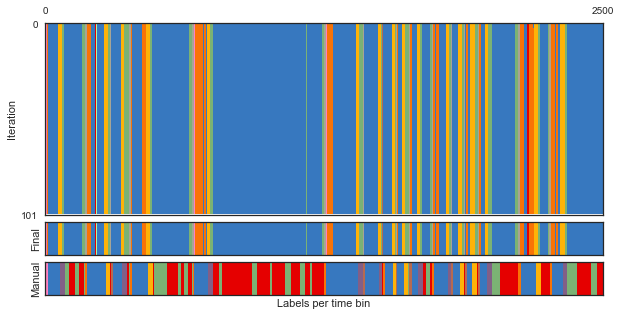

In [36]:
# Note: name the files (r)ecuzrrent (h)ierarhical instead of hr... 
#       this will make it easier to navigate the results directory
for worm in range(N_worms):
    plot_discrete_state_samples(
        hrslds_z_smpls[worm], z_trues[worm], Kmax,
        filepath=os.path.join(results_dir, "rhslds_z_samples_worm{}.pdf".format(worm+1)))

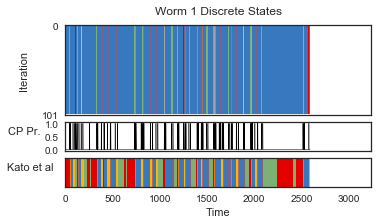

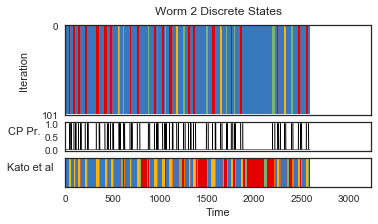

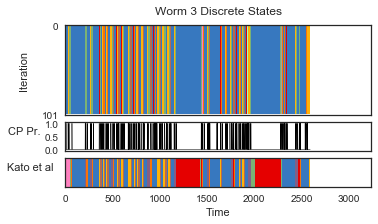

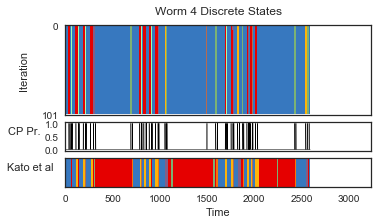

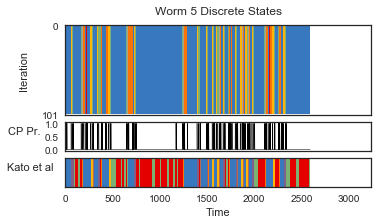

In [37]:
for worm in range(N_worms):
    plot_changepoint_prs(hrslds_z_smpls[worm], z_trues[worm],
                         title="Worm {} Discrete States".format(worm+1),
                         filepath=os.path.join(results_dir, "rhslds_cps_worm{}.pdf".format(worm+1)))

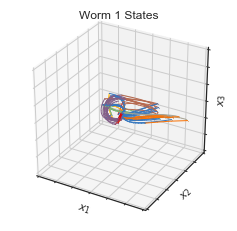

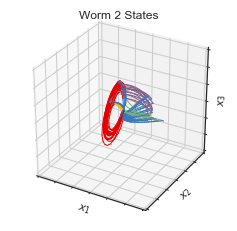

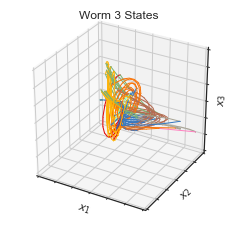

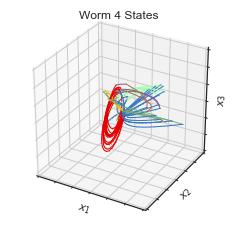

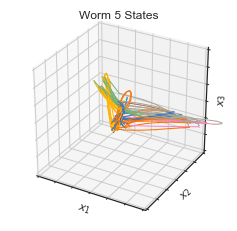

In [67]:
for worm in range(N_worms):
    plot_3d_continuous_states(hrslds_x_finals[worm], hrslds_z_finals[worm], colors,
                              figsize=(4, 4),
                              title="Worm {} States".format(worm + 1),
                              lim=6,
                              results_dir=results_dir,
                              filename="rhslds_x_worm_{}.pdf".format(worm + 1),
                              lw=1)

100%|██████████| 360/360 [00:39<00:00,  9.16it/s]


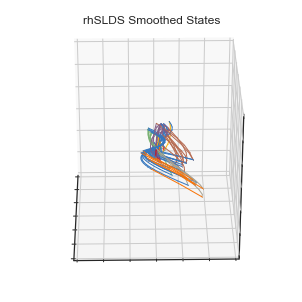

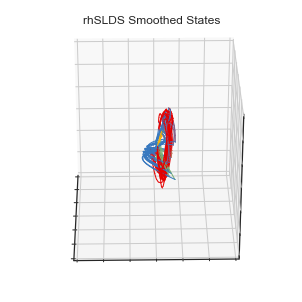

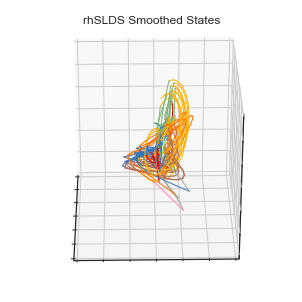

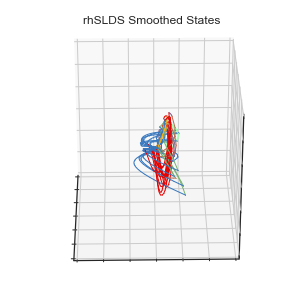

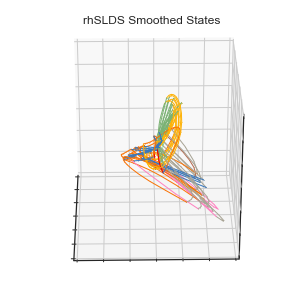

In [68]:
for worm in range(N_worms):
    make_states_3d_movie(hrslds_z_finals[worm], hrslds_x_finals[worm],
                         title="rhSLDS Smoothed States",
                         lim=6,
                         filepath=os.path.join(results_dir, "rhslds_x_worm{}.mp4".format(worm+1)))

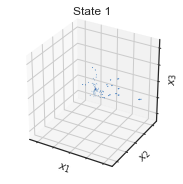

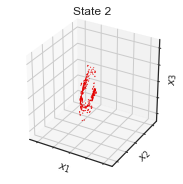

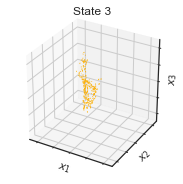

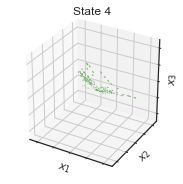

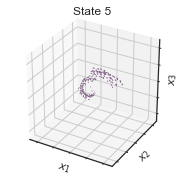

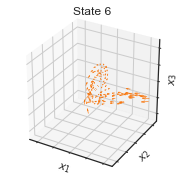

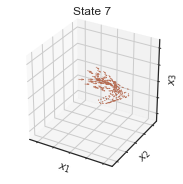

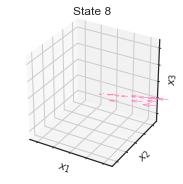

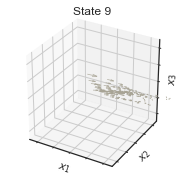

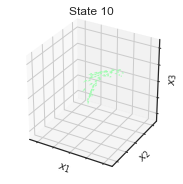

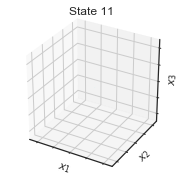

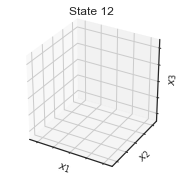

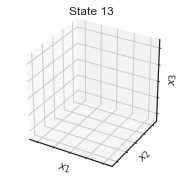

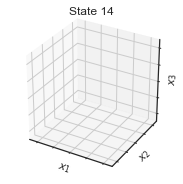

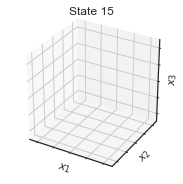

In [69]:
plot_3d_dynamics(
    hrslds_dynamics_distns, np.concatenate(hrslds_z_finals), np.vstack(hrslds_x_finals),
    colors=colors,
    lim=6,
    filepath=os.path.join(results_dir, "rhslds_dynamics.pdf"))


# Train a classifier to predict state from latent location

In [41]:
# Now try to estimate the transition probabilities
worm = 0
N_used = len(np.unique(hslds_z_finals[worm]))
from rslds.util import one_hot
from sklearn.linear_model.logistic import LogisticRegression
lr = LogisticRegression(verbose=False, multi_class="multinomial", solver="lbfgs")
# lr = LogisticRegression(verbose=False, multi_class="ovr")
lr_X = np.column_stack((one_hot(hslds.states_list[worm].stateseq[:-1], Kmax), 
                        hslds.states_list[worm].gaussian_states[:-1]))
lr_y = hslds.states_list[worm].stateseq[1:]
lr.fit(lr_X, lr_y)

# See how well the classifier performs|
lr_score = lr.score(lr_X, lr_y)
lr_probs = lr.predict_proba(lr_X)
print(lr_score)
# print(lr_probs.round(3))

# lr = LogisticRegression(verbose=False, multi_class="multinomial", solver="lbfgs")
# lr = LogisticRegression(verbose=False, multi_class="ovr")
# lr_X = np.column_stack((one_hot(hslds.states_list[worm].stateseq[:-1], Kmax), 
#                         hslds.states_list[worm].gaussian_states[:-1]))
# lr_y = hslds.states_list[worm].stateseq[1:]
# lr.fit(lr_X, lr_y)

# # See how well the classifier performs|
# lr_score = lr.score(lr_X, lr_y)
# lr_probs = lr.predict_proba(lr_X)
# print(lr_score.round(3))
# print(lr_probs.round(3))

# print(lr.coef_[:,Kmax:].round(2).T)

0.958317252026


In [42]:
# hrslds2 = copy_hslds_to_hrslds(hslds)
W = hrslds.trans_distn.W
logpi = hrslds.trans_distn.logpi
lr2 = LogisticRegression(verbose=False, multi_class="multinomial", solver="lbfgs")
lr2.fit(np.random.randn(Kmax, Kmax + D_latent), np.arange(Kmax))
lr2.coef_ = np.vstack((logpi, W)).T
lr2.intercept_ = np.zeros(Kmax)

for worm in range(N_worms):
    lr_X = np.column_stack((one_hot(hrslds.states_list[worm].stateseq[:-1], Kmax), 
                            hrslds.states_list[worm].gaussian_states[:-1]))
    lr_y = hrslds.states_list[worm].stateseq[1:]

    print(lr2.score(lr_X, lr_y))


0.960632960247
0.967966036279
0.949440370513
0.976071015052
0.957545349286


# Simulate from the models

In [43]:
T_gen = 2000
inputs = np.ones((T_gen, 1))
worm_to_simulate = 0

In [44]:
print("Simulating hSLDS")

# Basically fix the initial condition.
init_dynamics_distns = [
    Gaussian(nu_0=D_latent + 2, sigma_0=3. * np.eye(D_latent), mu_0=np.zeros(D_latent), kappa_0=0.01,
             mu=hslds_x_finals[worm_to_simulate][0], sigma=0.01 * np.eye(D_latent))
    for _ in range(Kmax)]
hrslds.init_dynamics_distns = init_dynamics_distns

# Turn down the dynamics noise
orig_hslds_dynamics_distns = copy.deepcopy(hslds.dynamics_distns)
# for dd in hslds.dynamics_distns:
#     dd.sigma *= 0.01    

hslds_y_gen, hslds_x_gen, hslds_z_gen = hslds.generate(T=T_gen, inputs=inputs, group=worm_to_simulate, keep=False)
print("Done")

hslds.dynamics_distns = orig_hslds_dynamics_distns


Simulating hSLDS
Done


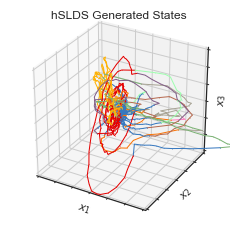

In [45]:
plot_3d_continuous_states(hslds_x_gen, hslds_z_gen, colors,
                          figsize=(4, 4),
                          lim=6,
                          title="hSLDS Generated States",
                          results_dir=results_dir,
                          filename="hslds_generated_3d_states.pdf",
                          lw=1)

In [46]:
# make_states_3d_movie(hslds_z_gen, hslds_x_gen,
#                      title="hSLDS Generated States",
#                      filepath=os.path.join(results_dir, "hslds_generated_states.mp4"))

## Simulate the recurrent hSLDS

In [47]:
print("Simulating recurrent hSLDS")

# Basically fix the initial condition.
init_dynamics_distns = [
    Gaussian(nu_0=D_latent + 2, sigma_0=3. * np.eye(D_latent), mu_0=np.zeros(D_latent), kappa_0=0.01,
             mu=hslds_x_finals[worm_to_simulate][0], sigma=0.01 * np.eye(D_latent))
    for _ in range(Kmax)]
hrslds.init_dynamics_distns = init_dynamics_distns

# Turn down the dynamics noise
orig_hrslds_dynamics_distns = copy.deepcopy(hrslds.dynamics_distns)
for dd in hrslds.dynamics_distns:
    dd.sigma *= 0.01
    
hrslds_y_gen, hrslds_x_gen, hrslds_z_gen = \
    hrslds.generate(T=T_gen, inputs=inputs, group=1, with_noise=True, keep=False)
hrslds.dynamics_distns = orig_hrslds_dynamics_distns
print("Done")

Simulating recurrent hSLDS
Done


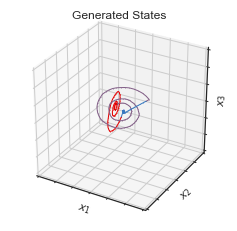

In [48]:
plot_3d_continuous_states(np.hstack((hrslds_x_gen, np.ones((T_gen, 1)))), 
                          hrslds_z_gen, 
                          colors,
                          figsize=(4, 4),
                          title="Generated States",
                          lim=6,
                          results_dir=results_dir,
                          filename="rhslds_generated_3d_states.pdf",
                          lw=1)
# plt.gca().plot([init_dynamics_distns[0].mu[0]],
#                [init_dynamics_distns[0].mu[1]],
#                [init_dynamics_distns[0].mu[2]], 'ko')

# plt.gca().plot([0], [0], [0], 'k*')
# plt.xlim(-6,6)
# plt.ylim(-6,6)
# plt.gca().set_zlim(-6,6)

100%|██████████| 360/360 [00:15<00:00, 23.94it/s]


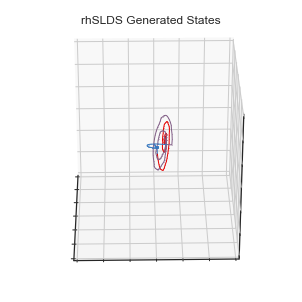

In [49]:
make_states_3d_movie(hrslds_z_gen, hrslds_x_gen,
                     title="rhSLDS Generated States", 
                     lim=6,
                     filepath=os.path.join(results_dir, "rhslds_generated_states.mp4"))

In [50]:
# neurons_to_plot = ["AVAL", "AVAR", "AVBL", "AVER", "RIML", "RIMR"]
# inds = np.concatenate([np.where(all_neuron_names==name) for name in neurons_to_plot]).ravel()
# plot_generated_neural_activity(datasets[worm][:T_gen, inds], neurons_to_plot, title="Actual Data", filename="actual_data.pdf")
# plot_generated_neural_activity(rslds_y_gen[:, inds], neurons_to_plot, title="Generated Data", filename="rslds_data.pdf")
# plt.show()

# Predictive Likelihood Tests

In [51]:
# # Compute the baseline likelihood under a simple Gaussian model pooling over worms
# all_data = np.vstack(datasets)
# all_masks = np.vstack(data_masks)
# all_train_masks = np.vstack(masks)
# all_test_masks = np.vstack(test_masks)

# normal_ll = lambda x, m, s: -0.5 * np.log(2 * np.pi * s) -0.5 * (x-m)**2 / s


# N = all_data.shape[1]
# mus = np.zeros(N)
# sigmasqs = np.zeros(N)
# for n in range(N):
#     mus[n] = all_data[all_train_masks[:,n],n].mean()
    
#     alpha_post = alpha_0 + all_train_masks[:,n].sum() / 2.0
#     beta_post = beta_0 + np.sum((all_data[all_train_masks[:,n],n] - mus[n])**2) / 2.0 
#     sigmasqs[n] = beta_post / (alpha_post + 1.0)
#     # sigmasqs[n] = all_data[all_train_masks[:,n],n].var()

# plt.errorbar(np.arange(N), mus, yerr=np.sqrt(sigmasqs))
# plt.xlabel("neuron")

# baseline_test = normal_ll(all_data, mus, sigmasqs)[all_test_masks].sum()
# baseline_train = normal_ll(all_data, mus, sigmasqs)[all_train_masks].sum()

In [52]:
# Compute the baseline likelihood under separate Gaussian models for each worm
# all_data = np.vstack(datasets)
# all_masks = np.vstack(data_masks)
# all_train_masks = np.vstack(masks)
# all_test_masks = np.vstack(test_masks)

normal_ll = lambda x, m, s: -0.5 * np.log(2 * np.pi * s) -0.5 * (x-m)**2 / s

baseline_train = 0
baseline_test = 0

for worm in range(N_worms):
    Y, Y_test, M, M_test = datasets[worm], datasets_test[worm], data_masks[worm], data_masks_test[worm]
    N = Y.shape[1]
    mus = np.zeros(N)
    sigmasqs = np.ones(N)
    for n in range(N):
        if not np.any(M[:,n]):
            continue
            
        mus[n] = Y[M[:,n],n].mean()

        alpha_post = alpha_0 + M[:,n].sum() / 2.0
        beta_post = beta_0 + np.sum((Y[M[:,n],n] - mus[n])**2) / 2.0 
        sigmasqs[n] = beta_post / (alpha_post + 1.0)

    baseline_test += normal_ll(Y_test, mus, sigmasqs)[M_test].sum()
    baseline_train += normal_ll(Y, mus, sigmasqs)[M].sum()

In [53]:
print(baseline_train)
# print(lds.heldout_log_likelihood(masks))
print(sum([model.heldout_log_likelihood([mask]) for model, mask in zip(ldss, masks)]))
# print(slds.heldout_log_likelihood(masks))
print(sum([model.heldout_log_likelihood([mask]) for model, mask in zip(sldss, masks)]))
print(hslds.heldout_log_likelihood(masks))
print(hrslds.heldout_log_likelihood( masks))

3998872.71092
4066874.5831
4071098.5085
4064311.78597
4064357.12917


3270.70706061
3186.19189448
3229.67879979
3101.00931744


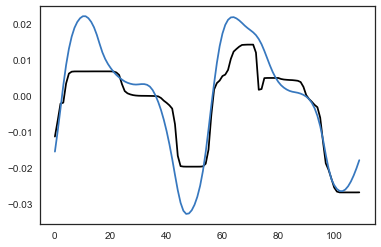

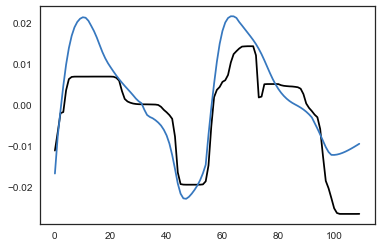

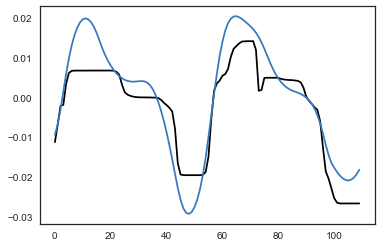

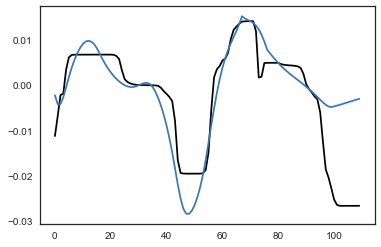

In [54]:
def rolling_predictive_likelihood(model, data, mask, offset=100, window=10, N_steps=100, **kwargs):
    
    train_mask = mask.copy()
    train_mask = train_mask[:offset+window]
    train_mask[offset:] = False

    test_mask = mask.copy()
    test_mask = test_mask[:offset+window]
    test_mask[:offset] = False

    inputs = np.ones((offset+window, 1))
    model.add_data(data[:offset+window], inputs=inputs, mask=train_mask, **kwargs)
    states = model.states_list.pop()
    if hasattr(states, '_init_vbem_from_gibbs'):
        states._init_vbem_from_gibbs()
    else:
        states._init_mf_from_gibbs()

    # Initialize expected states to be uniform
    E_z = np.ones_like(states.expected_states)
    E_z /= E_z.sum(1)[:,None]
    states.expected_states = E_z
    
    test_ll = 0
    for itr in range(N_steps):
        states.vb_E_step()
    test_ll += states.heldout_log_likelihood(test_mask)
    
    plt.figure()
    plt.plot(states.data[:,0], '-k')
    plt.plot(states.smooth()[:,0], color=colors[0])
    
    return test_ll
        
i = 2
print(rolling_predictive_likelihood(ldss[i], datasets_test[i], data_masks_test[i]))
print(rolling_predictive_likelihood(sldss[i], datasets_test[i], data_masks_test[i]))
print(rolling_predictive_likelihood(hslds, datasets_test[i], data_masks_test[i], group=i))
print(rolling_predictive_likelihood(hrslds, datasets_test[i], data_masks_test[i], group=i))

In [55]:
# print(baseline_test)
# # print(lds.heldout_log_likelihood(test_masks))
# print(sum([model.heldout_log_likelihood([test_mask]) for model, test_mask in zip(ldss, test_masks)]))
# # print(slds.heldout_log_likelihood(test_masks))
# print(sum([model.heldout_log_likelihood([test_mask]) for model, test_mask in zip(sldss, test_masks)]))
# print(hslds.heldout_log_likelihood(test_masks))
# print(hrslds.heldout_log_likelihood(test_masks))

1000044.46086


NameError: name 'test_masks' is not defined

In [ ]:
# Look for evidence of difference in variance. 
S = np.array([np.diag(S) for S in hrslds.emission_distns[0].sigma])
for worm in range(N_worms):
    S[worm] *= np.any(data_masks[worm], axis=0)

plt.figure()
plt.imshow(np.sqrt(S[:,:50]), aspect="auto", vmin=0, vmax=0.1)
plt.colorbar()

S_indep = np.array([np.diag(slds.emission_distns[0].sigma) for slds in sldss])
for worm in range(N_worms):
    S_indep[worm] *= np.any(data_masks[worm], axis=0)

plt.figure()
plt.imshow(np.sqrt(S_indep[:,:50]), aspect="auto", vmin=0, vmax=0.1)
plt.colorbar()
    
# S_marg = np.diag(slds.emission_distns[0].sigma)
# S_full = np.row_stack((S, S_marg, sigmasqs))
# plt.imshow(np.sqrt(S_full[:,:50]), aspect="auto", vmin=0)
# plt.colorbar()
